# Advanced Regression Techniques, Kaggle Competition
Hello World! This jupyter python notebook contains my personal attempt for the *"getting started"* kaggle competititon about regression techniques. Currently I am focused on XGBoost models and I will move on to Random Forest, Deep Learning etc. Last but not least thorough grid search - fine tuning has led to submissions that reach to top 30% (or 0.13 error of prediction) from all the other predictions.

*This tutorial is part of the [Learn Machine Learning](https://www.kaggle.com/dansbecker/learn-machine-learning) series. In this step, you will learn how to build and optimize models with the powerful xgboost library.* 

# What is XGBoost

**XGBoost** is the leading model for working with standard tabular data (the type of data you store in Pandas DataFrames, as opposed to more exotic types of data like images and videos). XGBoost models dominate many Kaggle competitions. 

To reach peak accuracy, XGBoost models require more knowledge and  _model tuning_ than techniques like Random Forest. After this tutorial, you'ill be able to 
- Follow the full modeling workflow with XGBoost 
- Fine-tune XGBoost models for optimal performance


XGBoost is an implementation of the **Gradient Boosted Decision Trees** algorithm (scikit-learn has another version of this algorithm, but XGBoost has some technical advantages.)  What is **Gradient Boosted Decision Trees**?  We'll walk through a diagram.

![xgboost image](https://i.imgur.com/e7MIgXk.png)

We go through cycles that repeatedly builds new models and combines them into an **ensemble** model.  We start the cycle by calculating the errors for each observation in the dataset.  We then build a new model to predict those.  We add predictions from this error-predicting model to the "ensemble of models."  

To make a prediction, we add the predictions from all previous models.  We can use these predictions to calculate new errors, build the next model, and add it to the ensemble.

There's one piece outside that cycle.  We need some base prediction to start the cycle. In practice, the initial predictions can be pretty naive. Even if it's predictions are wildly inaccurate, subsequent additions to the ensemble will address those errors.

This process may sound complicated, but the code to use it is straightforward. We'll fill in some additional explanatory details in the **model tuning** section below.

---

# Example

We will start with the data pre-loaded into **train_X**, **test_X**, **train_y**, **test_y**.

In [4]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import Imputer

data = pd.read_csv('../input/train.csv')
data.dropna(axis=0, subset=['SalePrice'], inplace=True)
y = data.SalePrice
X = data.drop(['SalePrice'], axis=1).select_dtypes(exclude=['object'])
train_X, test_X, train_y, test_y = train_test_split(X.as_matrix(), y.as_matrix(), test_size=0.25)

my_imputer = Imputer()
train_X = my_imputer.fit_transform(train_X)
test_X = my_imputer.transform(test_X)


We build and fit a model just as we would in scikit-learn.

In [5]:
from xgboost import XGBRegressor

my_model = XGBRegressor()
# Add silent=True to avoid printing out updates with each cycle
my_model.fit(train_X, train_y, verbose=False)


We similarly evaluate a model and make predictions as we would do in scikit-learn.

In [6]:
# make predictions
predictions = my_model.predict(test_X)

from sklearn.metrics import mean_absolute_error
print("Mean Absolute Error : " + str(mean_absolute_error(predictions, test_y)))

---
# Model Tuning

XGBoost has a few parameters that can dramatically affect your model's accuracy and training speed.  The first parameters you should understand are:

### n_estimators and early_stopping_rounds
**n_estimators** specifies how many times to go through the modeling cycle described above.  

In the [underfitting vs overfitting graph](http://i.imgur.com/2q85n9s.png), n_estimators moves you further to the right.  Too low a value causes underfitting, which is inaccurate predictions on both training data and new data. Too large a value causes overfitting, which is accurate predictions on training data, but inaccurate predictions on new data (which is what we care about). You can experiment with your dataset to find the ideal.  Typical values range from 100-1000, though this depends a lot on the **learning rate** discussed below.

The argument **early_stopping_rounds** offers a way to automatically find the ideal value. Early stopping causes the model to stop iterating when the validation score stops improving, even if we aren't at the hard stop for n_estimators.  It's smart to set a high value for **n_estimators** and then use **early_stopping_rounds** to find the optimal time to stop iterating.

Since random chance sometimes causes a single round where validation scores don't improve, you need to specify a number for how many rounds of straight deterioration to allow before stopping.  **early_stopping_rounds = 5** is a reasonable value.  Thus we stop after 5 straight rounds of deteriorating validation scores.

Here is the code to fit with early_stopping:

In [7]:
my_model = XGBRegressor(n_estimators=1000)
my_model.fit(train_X, train_y, early_stopping_rounds=5, 
             eval_set=[(test_X, test_y)], verbose=False)


When using **early_stopping_rounds**, you need to set aside some of your data for checking the number of rounds to use.  If you later want to fit a model with all of your data, set **n_estimators** to whatever value you found to be optimal when run with early stopping.

### learning_rate
Here's a subtle but important trick for better XGBoost models:

Instead of getting predictions by simply adding up the predictions from each component model, we will multiply the predictions from each model by a small number before adding them in.  This means each tree we add to the ensemble helps us less.  In practice, this reduces the model's propensity to overfit.

So, you can use a higher value of **n_estimators** without overfitting.  If you use early stopping, the appropriate number of trees will be set automatically.

In general, a small learning rate (and large number of estimators) will yield more accurate XGBoost models, though it will also take the model longer to train since it does more iterations through the cycle.

Modifying the example above to include a learing rate would yield the following code:

In [8]:
my_model = XGBRegressor(n_estimators=1000, learning_rate=0.05)
my_model.fit(train_X, train_y, early_stopping_rounds=5, 
             eval_set=[(test_X, test_y)], verbose=False)


### n_jobs
On larger datasets where runtime is a consideration, you can use parallelism to build your models faster.  It's common to set the parameter **n_jobs** equal to the number of cores on your machine.  On smaller datasets, this won't help. 

The resulting model won't be any better, so micro-optimizing for fitting time is typically nothing but a distraction. But, it's useful in large datasets where you would otherwise spend a long time waiting during the `fit` command.

XGBoost has a multitude of other parameters, but these will go a very long way in helping you fine-tune your XGBoost model for optimal performance.

# Conclusion
XGBoost is currently the dominant algorithm for building accurate models on conventional data (also called tabular or strutured data).  Go apply it to improve your models!

# Your Turn
Convert yuor model to use XGBoost.

Use early stopping to find a good value for n_estimators.  Then re-estimate the model with all of your training data, and that value of n_estimators.

Once you've done this, return to **[Learning Machine Learning](https://www.kaggle.com/dansbecker/learn-machine-learning)**, to keep improving..  



In [2]:
import pandas as pd
train_data = pd.read_csv('input/train.csv')
train_data.describe()

,Id,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,...,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SalePrice
count,1460.000000,1460.000000,1201.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1452.000000,1460.000000,...,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000
mean,730.500000,56.897260,70.049958,10516.828082,6.099315,5.575342,1971.267808,1984.865753,103.685262,443.639726,...,94.244521,46.660274,21.954110,3.409589,15.060959,2.758904,43.489041,6.321918,2007.815753,180921.195890
std,421.610009,42.300571,24.284752,9981.264932,1.382997,1.112799,30.202904,20.645407,181.066207,456.098091,...,125.338794,66.256028,61.119149,29.317331,55.757415,40.177307,496.123024,2.703626,1.328095,79442.502883
min,1.000000,20.000000,21.000000,1300.000000,1.000000,1.000000,1872.000000,1950.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,2006.000000,34900.000000
25%,365.750000,20.000000,59.000000,7553.500000,5.000000,5.000000,1954.000000,1967.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,5.000000,2007.000000,129975.000000
50%,730.500000,50.000000,69.000000,9478.500000,6.000000,5.000000,1973.000000,1994.000000,0.000000,383.500000,...,0.000000,25.000000,0.000000,0.000000,0.000000,0.000000,0.000000,6.000000,2008.000000,163000.000000
75%,1095.250000,70.000000,80.000000,11601.500000,7.000000,6.000000,2000.000000,2004.000000,166.000000,712.250000,...,168.000000,68.000000,0.000000,0.000000,0.000000,0.000000,0.000000,8.000000,2009.000000,214000.000000
max,1460.000000,190.000000,313.000000,215245.000000,10.000000,9.000000,2010.000000,2010.000000,1600.000000,5644.000000,...,857.000000,547.000000,552.000000,508.000000,480.000000,738.000000,15500.000000,12.000000,2010.000000,755000.000000


## XGboost Tuning and building models
Let's build and tune new models before submission, the following snippet preprocess the train and test set by filling the missing values using the Imputer class. Finally a XGBoost model is built and predictions with dafault parameters are made.

In [2]:
'''
My turn to write some code ;) and lets have a project submission
this snippet of code cleans the data and fill the missing values with the Imputer class
then build a xgboost model using with default parameters 
'''

#load some libraries
import pandas as pd
from sklearn.preprocessing import Imputer

# Read the data
train_data = pd.read_csv('input/train.csv')
test_data = pd.read_csv('input/test.csv')

#seperate the target variable
train_data_y = train_data.SalePrice

#exclude Id columns from train and test data
train_data = train_data.drop(['Id', 'SalePrice'], axis = 1)
test_data = test_data.drop(['Id'], axis = 1)

#due to the fact that train and test data do not have the same amount of columns we will train the models with the intersection of their columns
common_columns = train_data.columns.intersection(test_data.columns)
train_data = train_data[common_columns]
test_data = test_data[common_columns]

#create a dataframe named as train_data_numeric from train data and fill the missing values with the mean from each columns using the Imputer class
train_data_numeric = train_data.select_dtypes(exclude=['object'])
train_data_numeric_columns = train_data_numeric.columns
my_imputer = Imputer()
train_data_numeric = my_imputer.fit_transform(train_data_numeric)
train_data_numeric = pd.DataFrame(train_data_numeric, columns = train_data_numeric_columns)

#a function to find the difference between two dataframes
def df_diff(first, second):
        second = set(second)
        return [item for item in first if item not in second]

#train_data non numeric columns into one hot encoding
train_data_non_numeric = train_data[df_diff(train_data.columns, train_data_numeric.columns)]
train_data_non_numeric = pd.get_dummies(train_data_non_numeric)

#concat the numeric and non_numeric dataframes into one
train_data_preprocessed = pd.concat([train_data_numeric.reset_index(drop=True), train_data_non_numeric], axis=1)

#do the exact same thing with test data
test_data_numeric = test_data.select_dtypes(exclude=['object'])
test_data_numeric_columns = test_data_numeric.columns
my_imputer = Imputer()
test_data_numeric = my_imputer.fit_transform(test_data_numeric)
test_data_numeric = pd.DataFrame(test_data_numeric, columns = test_data_numeric_columns)

#train_data non numeric columns into one hot encoding process
test_data_non_numeric = test_data[df_diff(test_data.columns, test_data_numeric.columns)]
test_data_non_numeric = pd.get_dummies(test_data_non_numeric)

#concat the numeric and non_numeric dataframes into one
test_data_preprocessed = pd.concat([test_data_numeric.reset_index(drop=True), test_data_non_numeric], axis=1)

#get again the common columns between train and test data
common_columns = test_data_preprocessed.columns.intersection(train_data_preprocessed.columns)
test_data_preprocessed = test_data_preprocessed[common_columns]
train_data_preprocessed = train_data_preprocessed[common_columns]

#start training and predicting
from xgboost import XGBRegressor

my_model = XGBRegressor()
# Add silent=True to avoid printing out updates with each cycle
my_model.fit(train_data_preprocessed, train_data_y)

# make predictions
predictions_prices = my_model.predict(test_data_preprocessed)

test_data = pd.read_csv('input/test.csv')
my_submission = pd.DataFrame({'Id': test_data.Id, 'SalePrice': predictions_prices})

# you could use any filename. We choose submission here
my_submission.to_csv('submission_xgboost_default_parameters.csv', index=False)

## Tuning XGBoost models
Here comes the fun part, the tuning, actually it takes a lot of time, it may needs 2 days to finish but we will take a better model that we fit more efficiently the data.

### XGBoost fine tuning, full version

In [10]:
'''
Experimenting with a full  Grid Search and make new predictions with the best parameters
this grid search it will take time to finish, approximately it will take 3-4 days depending on 
the cpu power.
'''

parameters = {'max_depth':[2, 3, 4, 5], 'learning_rate':[0.3, 0.2, 0.1, 0.05, 0.01], 'n_estimators':[100, 200, 300, 400, 500], 
              'min_child_weight':[i for i in range(1,13)], 'gamma': [i/10.0 for i in range(0,2)], 'subsample':[i/10.0 for i in range(2,8)], 
              'colsample_bytree':[i/10.0 for i in range(2,8)], 'reg_alpha':[1e-5, 1e-4, 1e-3, 1e-2, 0.1, 1, 10]}

from sklearn.model_selection import GridSearchCV
from xgboost import XGBRegressor

my_model = XGBRegressor(seed=123)

clf = GridSearchCV(my_model, parameters, cv=4, scoring='r2', verbose = 6, n_jobs=2)
clf.fit(train_data_preprocessed, train_data_y)
print("best parameters after tuning:", clf.best_params_)

### A smaller version for fine tuning (1-2 day execution maximum)

In [16]:
'''
Experimenting with a smaller Grid Search and make new predictions with the best parameters
this grid search it will take time to finish, approximately it will take 1-2 days depending on 
the cpu power.
'''

parameters = {'max_depth':[2, 3, 4], 'learning_rate':[0.3, 0.25, 0.2], 'n_estimators':[200, 300, 400], 
              'min_child_weight':[i for i in range(1,8)], 'gamma': [i/10.0 for i in range(0,2)], 
              'subsample':[i/10.0 for i in range(2,8)], 
              'colsample_bytree':[i/10.0 for i in range(2,8)], 'reg_alpha':[1e-5, 1e-4, 1e-3]}

from sklearn.model_selection import GridSearchCV
from xgboost import XGBRegressor

my_model = XGBRegressor(seed=123)

clf = GridSearchCV(my_model, parameters, cv=4, scoring='r2', verbose = 0, n_jobs=2)
clf.fit(train_data_preprocessed, train_data_y)
print("best parameters after tuning:", clf.best_params_)

In [31]:
#print(clf.grid_scores_)

## Printing the best score

In [24]:
print(clf.best_score_)

0.9014833015421191


## Lets make predictions with the best tuned model

In [2]:
predictions_prices = clf.predict(test_data_preprocessed)

test_data = pd.read_csv('input/test.csv')
my_submission_grid = pd.DataFrame({'Id': test_data.Id, 'SalePrice': predictions_prices})

# you could use any filename. We choose submission here
my_submission_grid.to_csv('submission__xgboost_after_fine_tuned_grid.csv', index=False)

## Save the fine tuned xgboost model to disk for future references

In [52]:
#save the model
from sklearn.externals import joblib

joblib.dump(clf.best_estimator_, 'saved_model_fine_tune_xgboost.pkl')



['saved_model_fine_tune_xgboost.pkl']

In [30]:
# load the model from disk
loaded_model = joblib.load('saved_model.pkl')
print(loaded_model)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=0.6, gamma=0.0, learning_rate=0.2,
       max_delta_step=0, max_depth=2, min_child_weight=1, missing=nan,
       n_estimators=300, n_jobs=1, nthread=None, objective='reg:linear',
       random_state=0, reg_alpha=1e-05, reg_lambda=1, scale_pos_weight=1,
       seed=None, silent=True, subsample=0.9)


## XGBoost Feature importances
Lets find the most important features based on the feature weights, “weight” is the number of times a feature appears in a tree, [source](http://xgboost.readthedocs.io/en/latest/python/python_api.html#module-xgboost.plotting).

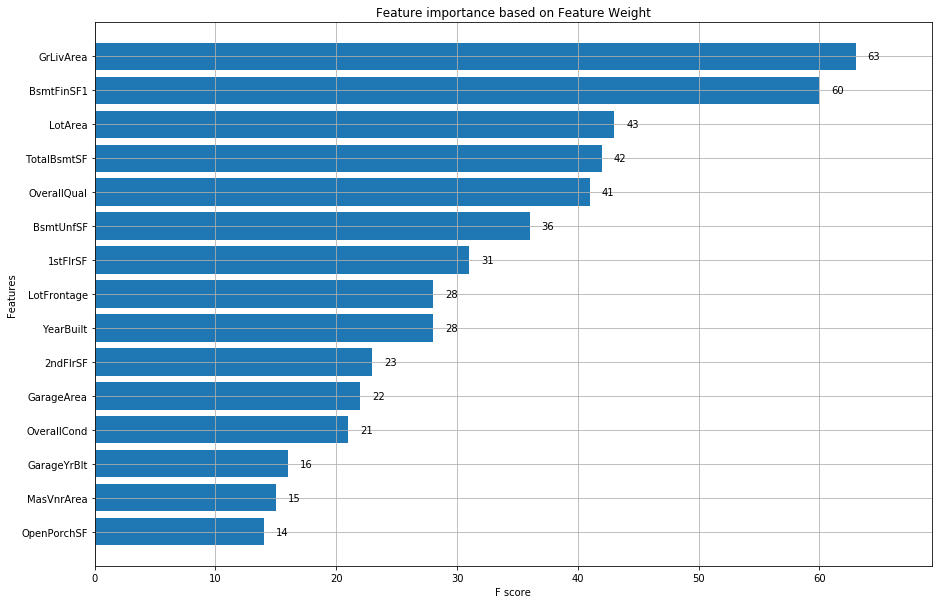

In [50]:
import xgboost
import matplotlib.pyplot as plt

plt.rcParams["figure.figsize"] = (15,10)

xgboost.plot_importance(loaded_model, max_num_features = 15, height=0.8, title='Feature importance based on Feature Weight', importance_type="weight")

# Random Forest Experimentation
*TBA*